In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import face_recognition
import dlib
import os

from PIL import Image
from tqdm import tqdm
from glob import glob

import tensorflow as tf

from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam


from utils.umeyama import umeyama

'''
Part of the code was modified from https://github.com/deepfakes/faceswap
'''

'\nPart of the code was modified from https://github.com/deepfakes/faceswap\n'

In [5]:
# Download and uncompress dlib model file
import urllib.request
url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
filepath = 'shape_predictor_68_face_landmarks.dat.bz2'
urllib.request.urlretrieve(url, filepath)

import bz2
zipfile = bz2.BZ2File(filepath)
data = zipfile.read() 
new_filepath = filepath.replace('.bz2','') 
open(new_filepath, 'wb').write(data);

In [11]:
SIZE = 64  # input size of autoencoder
IMAGE_SHAPE = (SIZE, SIZE, 3)

mean_face_x = np.array([
0.000213256, 0.0752622, 0.18113, 0.29077, 0.393397, 0.586856, 0.689483, 0.799124,
0.904991, 0.98004, 0.490127, 0.490127, 0.490127, 0.490127, 0.36688, 0.426036,
0.490127, 0.554217, 0.613373, 0.121737, 0.187122, 0.265825, 0.334606, 0.260918,
0.182743, 0.645647, 0.714428, 0.793132, 0.858516, 0.79751, 0.719335, 0.254149,
0.340985, 0.428858, 0.490127, 0.551395, 0.639268, 0.726104, 0.642159, 0.556721,
0.490127, 0.423532, 0.338094, 0.290379, 0.428096, 0.490127, 0.552157, 0.689874,
0.553364, 0.490127, 0.42689 ])

mean_face_y = np.array([
0.106454, 0.038915, 0.0187482, 0.0344891, 0.0773906, 0.0773906, 0.0344891,
0.0187482, 0.038915, 0.106454, 0.203352, 0.307009, 0.409805, 0.515625, 0.587326,
0.609345, 0.628106, 0.609345, 0.587326, 0.216423, 0.178758, 0.179852, 0.231733,
0.245099, 0.244077, 0.231733, 0.179852, 0.178758, 0.216423, 0.244077, 0.245099,
0.780233, 0.745405, 0.727388, 0.742578, 0.727388, 0.745405, 0.780233, 0.864805,
0.902192, 0.909281, 0.902192, 0.864805, 0.784792, 0.778746, 0.785343, 0.778746,
0.784792, 0.824182, 0.831803, 0.824182 ])

mean_face_landmarks = np.stack([mean_face_x, mean_face_y ], axis=1)

def get_align_mat(face_landmarks):
    return umeyama(face_landmarks[17:], 
                   mean_face_landmarks, True)[0:2]


predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def shape_to_np(shape):
    coords = []
    for i in range(0, shape.num_parts):        
        coords.append((shape.part(i).x, shape.part(i).y))
    return np.array(coords)

def _css_to_rect(css):
    return dlib.rectangle(css[3], css[0], css[1], css[2])

def align_face(face_image, affine_matrix, size, padding=48):
    affine_matrix = affine_matrix * (size - 2 * padding) 
    affine_matrix[:, 2] += padding
    warp_face = cv2.warpAffine(face_image, affine_matrix, (size, size))
    return warp_face


In [35]:
os.makedirs("data/images/a", exist_ok=True)
os.makedirs("data/images/b", exist_ok=True)
os.makedirs("data/faces/a", exist_ok=True)
os.makedirs("data/faces/b", exist_ok=True)
os.makedirs("output/images", exist_ok=True)
os.makedirs("saved_model", exist_ok=True)

# 1. Extract Images from Video
Unzip data.zip and the training face images are stored in data/faces/. You can replace that with your own images. 

You can also extract images from videos like shown below. It will extract video frames and store them as image in data/images. This can be used for inference (the video where you want to swap face), and to obtain faces for training.

In [ ]:
fdir = 'a'
video = 
start_time = "00:00" 
duration = "00:20"

!ffmpeg -ss $start_time -i $video -t $duration data/images/$fdir/image_%04d.png    

In [ ]:
fdir = 'b'
video = ""
start_time = "00:13" 
duration = "00:11"
!ffmpeg -ss $start_time -i $video -t $duration data/images/$fdir/image_%04d.png    

## This step will extract face from images. Skip to "2. Image Loader" if use provided data.

In [24]:
for fdir in ['a', 'b']:
    fnames = glob(f'data/images/{fdir}/*')
    for fname in tqdm(fnames):
        image = np.asarray(Image.open(fname))
        coords = face_recognition.face_locations(image, model='hog') # or cnn
        if len(coords)>0:
            coord = coords[0]
            coord = _css_to_rect(coord)
            face_landmarks = predictor(image, coord)
            face_landmarks = shape_to_np(face_landmarks)

            affine_matrix = get_align_mat(face_landmarks)
            aligned_face = align_face(image, affine_matrix, size=256)

            out_fname = fname.replace('/images/', '/faces/')
            Image.fromarray(aligned_face).save(out_fname)


100%|██████████| 275/275 [00:35<00:00,  7.76it/s]


# 2. Image Loader

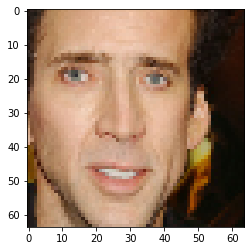

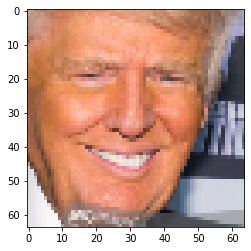

In [89]:
BATCH_SIZE = 64
BUFFER_SIZE = 300

random_transform_args = {
    'rotation_range': 10,
    'zoom_range': 0.05,
    'shift_range': 0.05,
    'random_flip': 0.4,
}

def random_transform(image, rotation_range, zoom_range, shift_range, random_flip):

    h, w = image.shape[0:2]
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    tx = np.random.uniform(-shift_range, shift_range) * w
    ty = np.random.uniform(-shift_range, shift_range) * h
    mat = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    mat[:, 2] += (tx, ty)
    result = cv2.warpAffine(
        image, mat, (w, h), borderMode=cv2.BORDER_REPLICATE)
    if np.random.random() < random_flip:
        result = result[:, ::-1]
    return result

def random_warp(image):
    coverage = 220
    assert image.shape == (256, 256, 3)
    range_ = np.linspace(128 - coverage//2, 128 + coverage//2, 5)
    mapx = np.broadcast_to(range_, (5, 5))
    mapy = mapx.T

    mapx = mapx + np.random.normal(size=(5, 5), scale=5)
    mapy = mapy + np.random.normal(size=(5, 5), scale=5)

    interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
    interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')

    warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)

    src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)
    dst_points = np.mgrid[0:65:16, 0:65:16].T.reshape(-1, 2)
    mat = umeyama(src_points, dst_points, True)[0:2]

    target_image = cv2.warpAffine(image, mat, (64, 64))

    return warped_image, target_image

def load_image(image_file):
    def load_data(image_file):
        # load
        fname = image_file.numpy().decode("utf-8")
        image = np.array(Image.open(fname), dtype=np.float32)/255.

        image = random_transform(image, **random_transform_args)    
        warped_image, target_image = random_warp(image)        
        return warped_image, target_image
    
    [warped_image, target_image] = tf.py_function(load_data, [image_file], [tf.float32, tf.float32])
    
    return warped_image, target_image

dataset_a = tf.data.Dataset.list_files("data/faces/a/*")
dataset_a = dataset_a.map(load_image,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_a = dataset_a.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

plt.imshow(next(iter(dataset_a))[0][0])
plt.show()

dataset_b = tf.data.Dataset.list_files("data/faces/b/*")
dataset_b = dataset_b.map(load_image,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_b = dataset_b.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

plt.imshow(next(iter(dataset_b))[0][0])
plt.show()


# 3. Define Autoencoder

In [92]:
def downsample(filters, name=''):
    return Sequential([
        Conv2D(filters, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(0.1)
    ], name=name)


def Encoder(z_dim=1024):
    inputs = Input(shape=IMAGE_SHAPE)
    x = inputs
    x = downsample(128, 'Downsample_1')(x)
    x = downsample(256, 'Downsample_2')(x)
    x = downsample(512, 'Downsample_3')(x)
    x = downsample(1024, 'Downsample_4')(x)
    
    x = Flatten()(x)
    x = Dense(z_dim)(x)
    x = Dense(4 * 4 * 1024)(x)
    x = Reshape((4, 4, 1024))(x)
    
    x = UpSampling2D((2,2))(x)
    out = Conv2D(512, kernel_size=3, strides=1, padding='same')(x)
        
    return Model(inputs=inputs, outputs=out, name='encoder')

def upsample(filters, name=''):
    return Sequential([
        UpSampling2D((2,2)),
        Conv2D(filters, kernel_size=3, strides=1, padding='same'),        
        LeakyReLU(0.1)
    ], name=name)
    
def Decoder(input_shape=(8, 8 ,512)):
    inputs = Input(shape=input_shape)
    x = inputs    
    x = upsample(256, "Upsample_1")(x)
    x = upsample(128, "Upsample_2")(x)
    x = upsample(64, "Upsample_3")(x)
    out = Conv2D(filters=3, kernel_size=5, padding='same', activation='sigmoid')(x)
    
    return Model(inputs=inputs, outputs=out, name='decoder')


In [ ]:
class DeepFake:
    def __init__(self, z_dim=1024):
        self.encoder = Encoder(z_dim)
        self.decoder_a = Decoder()
        self.decoder_b = Decoder()
        x = Input(shape=IMAGE_SHAPE)

        self.ae_a = Model(x, 
                          self.decoder_a(self.encoder(x)),
                          name="Autoencoder_A")
        
        self.ae_b = Model(x, 
                          self.decoder_b(self.encoder(x)),
                          name="Autoencoder_B")

        optimizer = Adam(5e-5, beta_1=0.5, beta_2=0.999)
        
        self.ae_a.compile(optimizer=optimizer, loss='mae')
        self.ae_b.compile(optimizer=optimizer, loss='mae')
    
    def show_image(self, image_a, image_b):
        result_a = self.ae_a.predict(image_a)
        result_b = self.ae_b.predict(image_b)
        # a to b
        face_a2b = self.decoder_b.predict(self.encoder.predict(image_a))
        # b to a
        face_b2a = self.decoder_a.predict(self.encoder.predict(image_b))
        
        grid_row = 2
        grid_col = 6
        
        scale = 4
        f, axarr = plt.subplots(grid_row, grid_col, 
                                figsize=(grid_col*scale, grid_row*scale))

        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            ax[0].imshow(image_a[row])
            ax[0].axis('off')
            ax[1].imshow(result_a[row])
            ax[1].axis('off')
            ax[2].imshow(face_a2b[row])
            ax[2].axis('off')
            
            ax[3].imshow(image_b[row])
            ax[3].axis('off')
            ax[4].imshow(result_b[row])
            ax[4].axis('off')
            ax[5].imshow(face_b2a[row])
            ax[5].axis('off')
            
        plt.show()

        

    def train_step(self, gen_a, gen_b):
        warped_a, target_a = next(gen_a)
        warped_b, target_b = next(gen_b)
        
        loss_a = self.ae_a.train_on_batch(warped_a, target_a)
        loss_b = self.ae_b.train_on_batch(warped_b, target_b)
        return loss_a, loss_b
    
    def train(self, gen_a, gen_b, steps, interval=100):
        for i in range(1, steps+1):
            loss_a, loss_b = self.train_step(gen_a, gen_b)
            if i% interval == 0:
                msg = f'Step {i} loss_a {loss_a:.4f} loss_b {loss_b:.4f}'
                print(msg)
                warped_a, target_a = next(gen_a)
                warped_b, target_b = next(gen_b)
                self.show_image(target_a, target_b)
                deepfake.encoder.save("saved_model/encoder")
                deepfake.decoder_a.save("saved_model/decoder_a")
                deepfake.decoder_b.save("saved_model/decoder_b")
                
        
deepfake = DeepFake()


Step 500 loss_a 0.0599 loss_b 0.0658


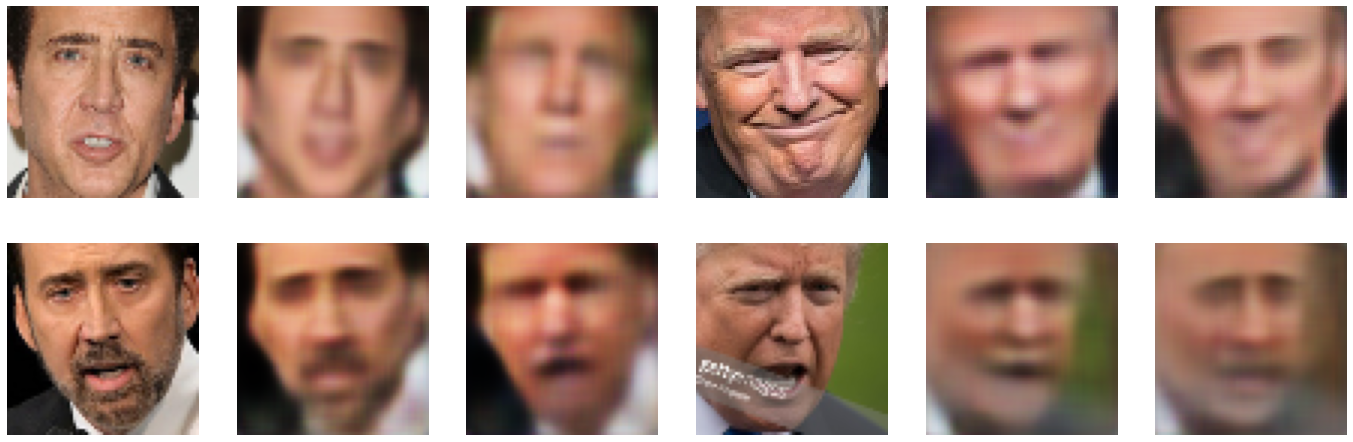

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 1000 loss_a 0.0567 loss_b 0.0597


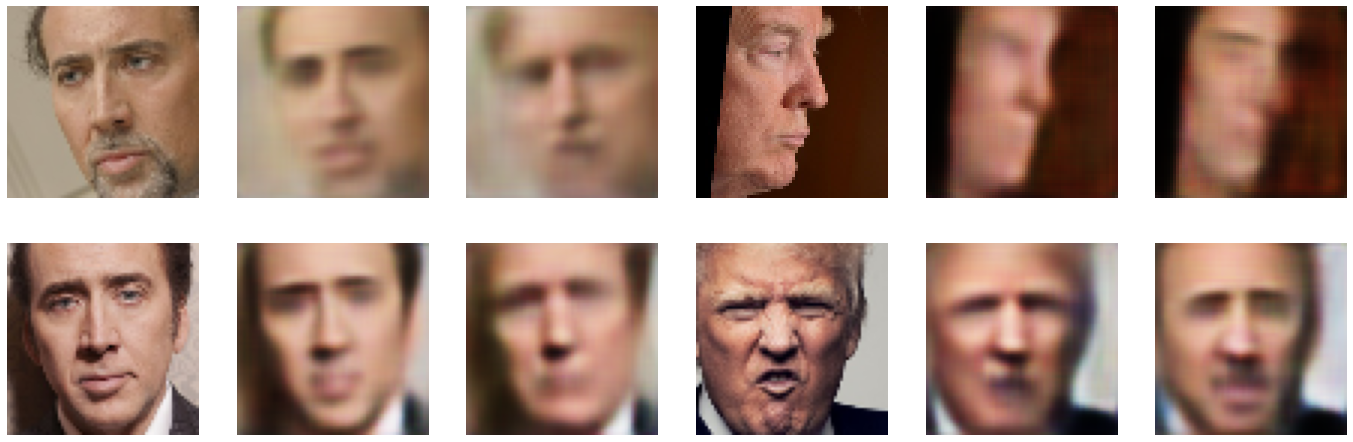

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 1500 loss_a 0.0547 loss_b 0.0576


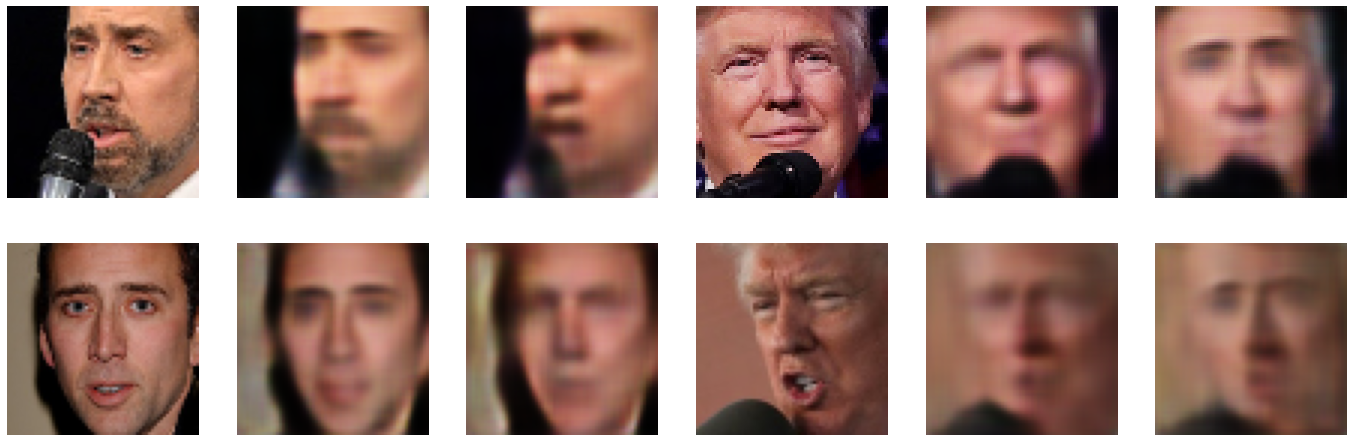

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 2000 loss_a 0.0517 loss_b 0.0565


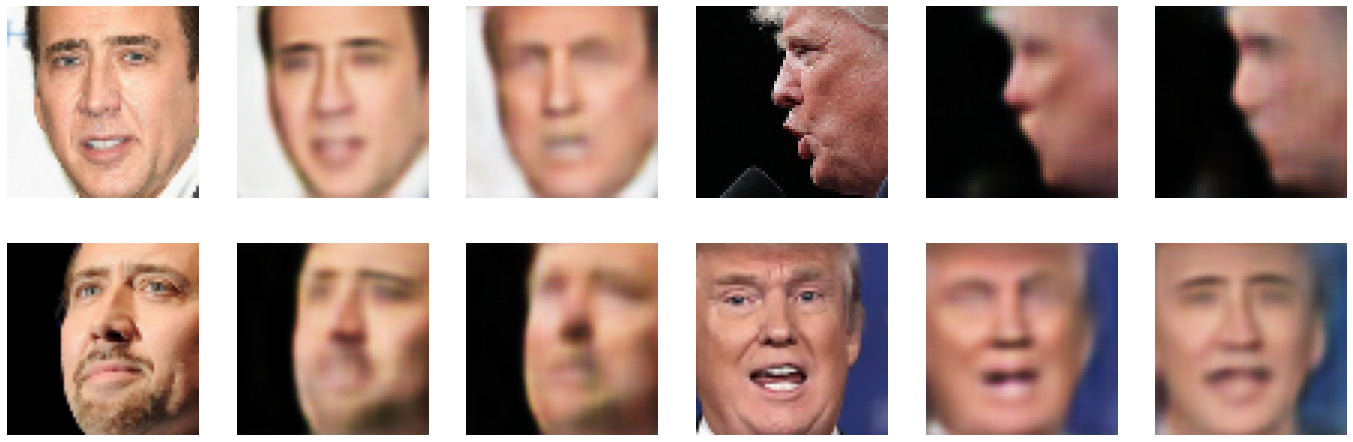

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 2500 loss_a 0.0517 loss_b 0.0498


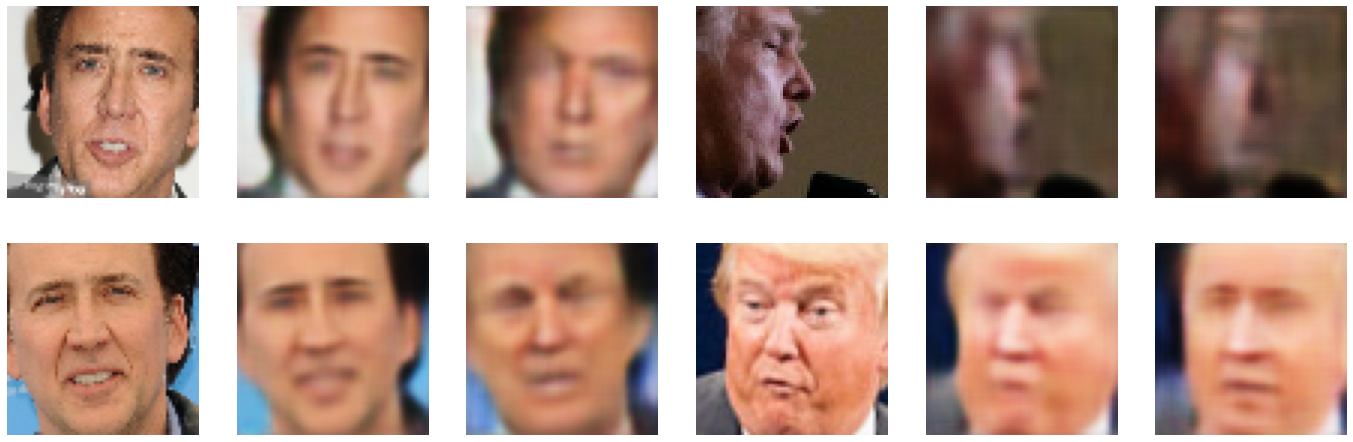

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 3000 loss_a 0.0498 loss_b 0.0512


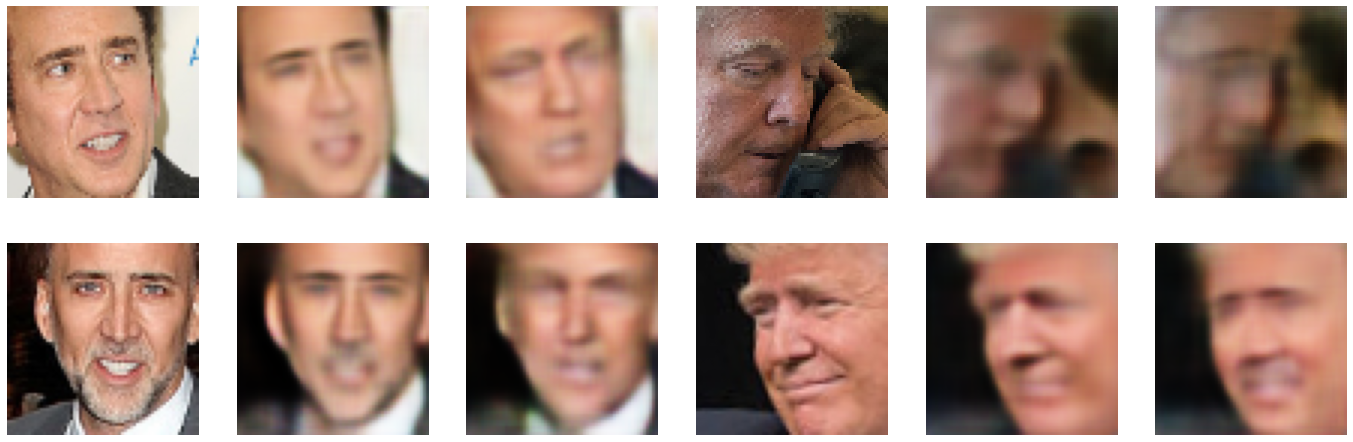

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 3500 loss_a 0.0550 loss_b 0.0512


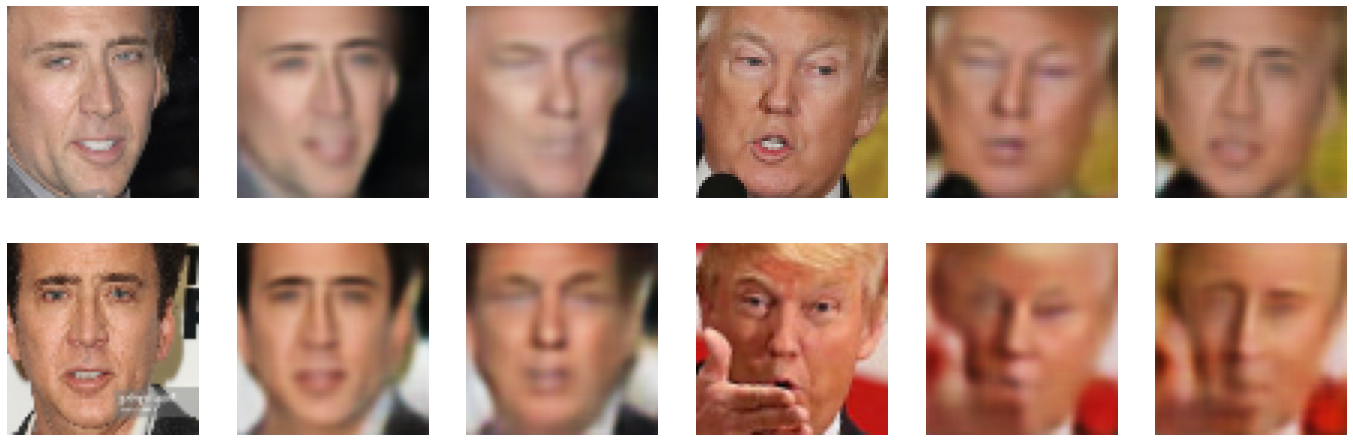

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 4000 loss_a 0.0477 loss_b 0.0473


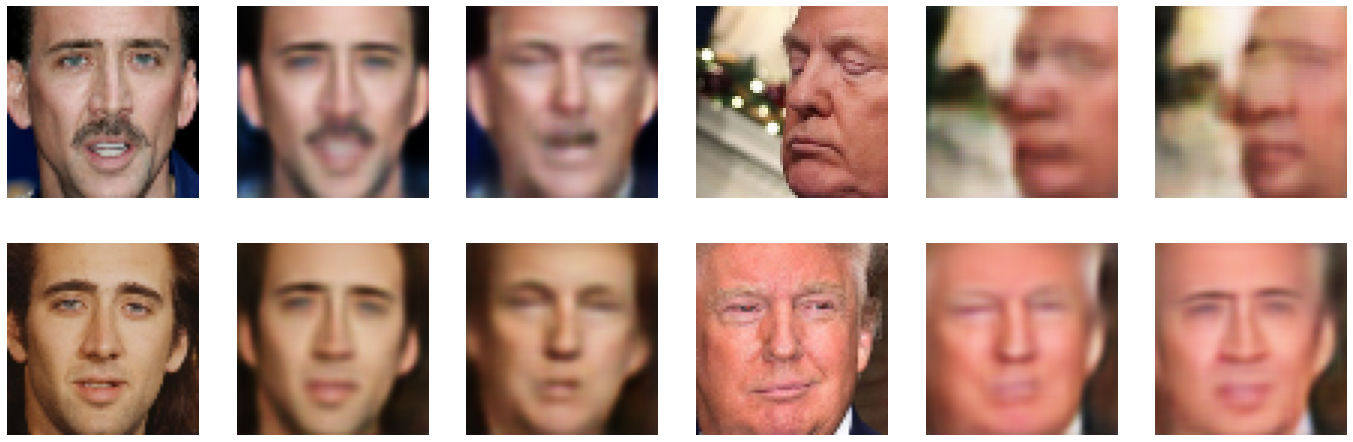

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 4500 loss_a 0.0481 loss_b 0.0479


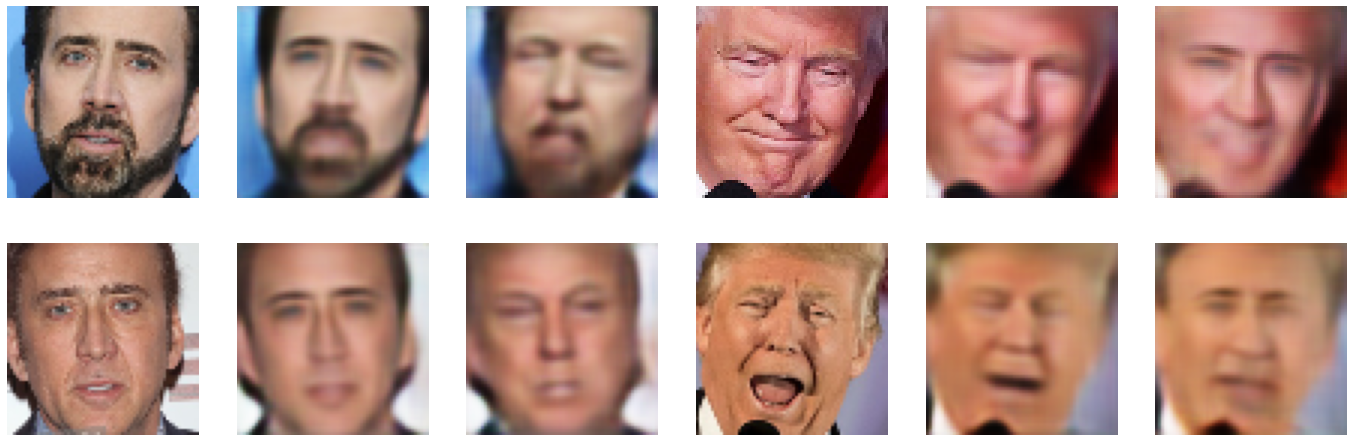

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 5000 loss_a 0.0463 loss_b 0.0464


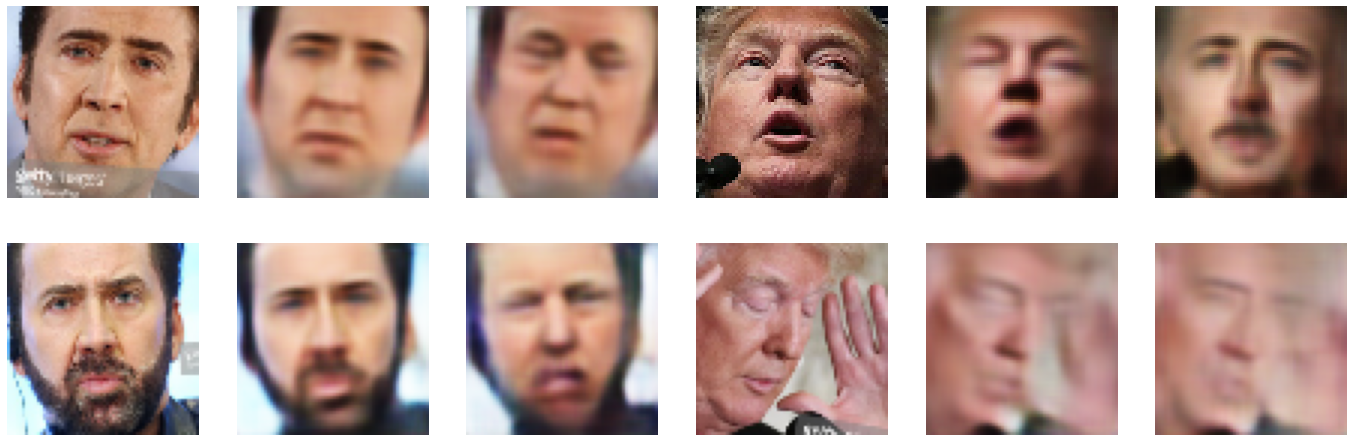

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 5500 loss_a 0.0465 loss_b 0.0472


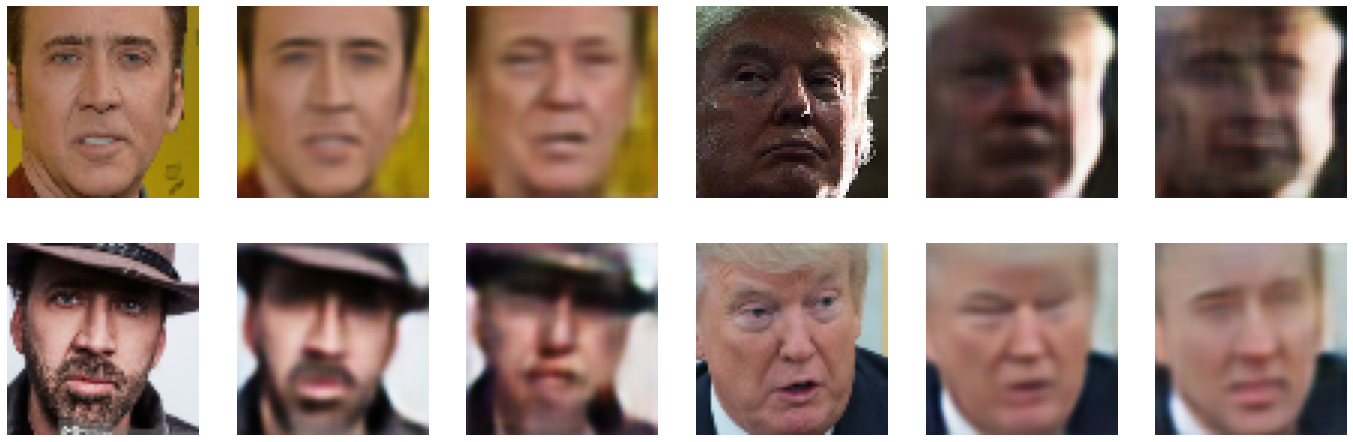

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 6000 loss_a 0.0456 loss_b 0.0467


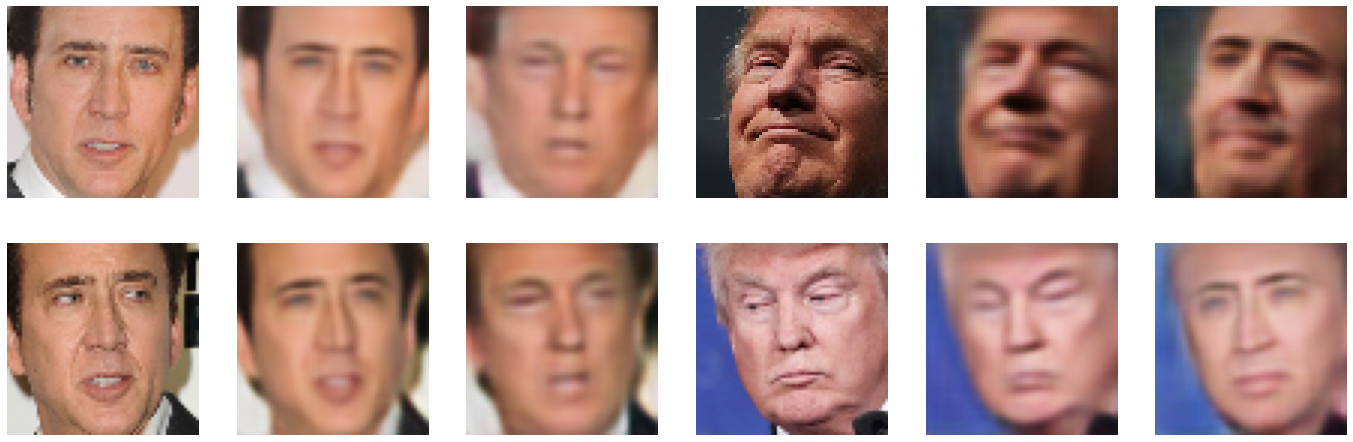

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 6500 loss_a 0.0436 loss_b 0.0461


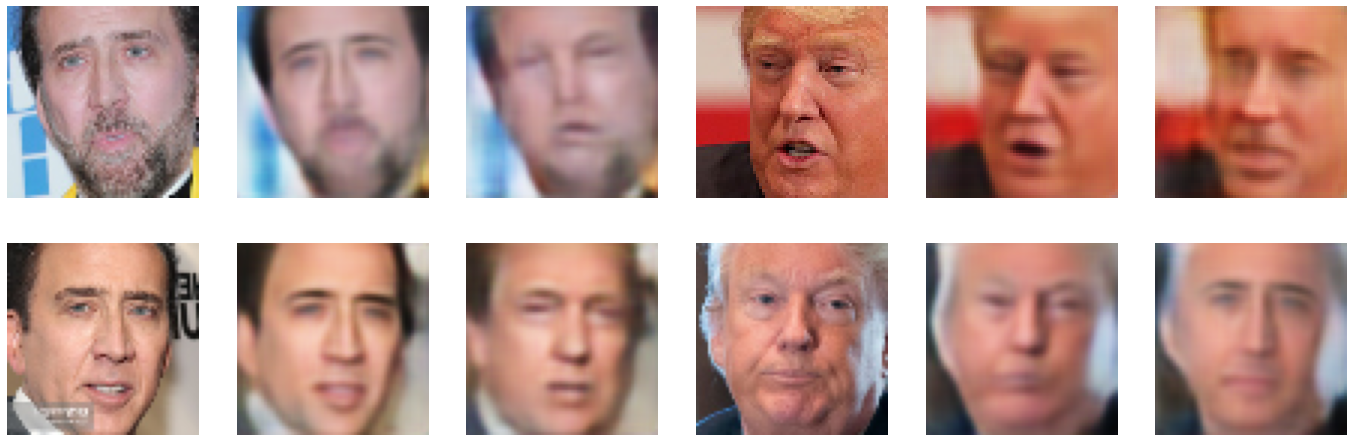

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets
Step 7000 loss_a 0.0447 loss_b 0.0448


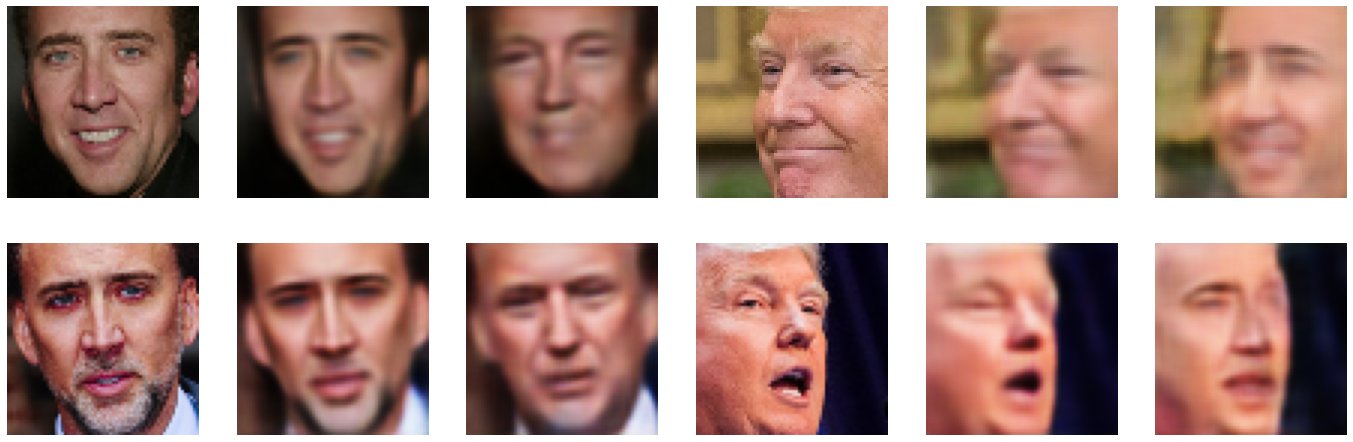

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder_a/assets
INFO:tensorflow:Assets written to: saved_model/decoder_b/assets


KeyboardInterrupt: 

In [99]:
deepfake.train(iter(dataset_a), iter(dataset_b), 6000, 500)

# 4. Swap Face

In [100]:
encoder = load_model("saved_model/encoder")
decoder_a = load_model("saved_model/decoder_a")
decoder_b = load_model("saved_model/decoder_b")

ae_a2b = Model(encoder.input, 
                    decoder_b(encoder.output))
ae_b2a = Model(encoder.input, 
                    decoder_a(encoder.output))


In [26]:
def get_hull_mask(image_shape, landmarks):
    # hull mask
    hull = cv2.convexHull(landmarks)
    hull_mask = np.zeros(image_shape, dtype=np.float32)
    hull_mask = cv2.fillConvexPoly(hull_mask, hull, (1,1,1))
    hull_mask = cv2.blur(hull_mask, (2, 2))
    return hull_mask

def get_rect_mask(image_shape, face_shape, affine_matrix):
    h, w, c = image_shape
    face_mask = np.zeros(image_shape, dtype=np.float32)
    face_src = np.ones(face_shape, dtype=np.float32)
    face_mask =  cv2.warpAffine(face_src, 
                                affine_matrix*SIZE, 
                                (w, h), face_mask, 
                                cv2.WARP_INVERSE_MAP, 
                                cv2.BORDER_TRANSPARENT)
    return face_mask

def get_mask(image_shape, face_shape, landmarks, affine_matrix):
    hull_mask = get_hull_mask(image_shape, landmarks)
    rect_mask = get_rect_mask(image_shape, face_shape, affine_matrix)
    mask = hull_mask * rect_mask
    mask = mask.astype(np.float32)
    return mask

def get_face(image):
    coords = face_recognition.face_locations(image, model='hog')
    if len(coords)>0:
        coord = coords[0]
        coord = _css_to_rect(coord)
        face_landmarks = predictor(image, coord)
        face_landmarks = shape_to_np(face_landmarks)

        affine_matrix = get_align_mat(face_landmarks)
  
        aligned_face = align_face(image, affine_matrix, size=SIZE, padding=0)
        
        face_mask = get_mask(image.shape, aligned_face.shape,
                             face_landmarks, affine_matrix)
                
        
        return aligned_face, affine_matrix, face_mask
    else:
        return None, None, None
    

def apply_face(image, new_image, mask):
    foreground = cv2.multiply(mask, new_image)
    base_image = np.copy(image/255).astype(np.float32)
    
    background = cv2.multiply(1 - mask, base_image)
    output_image = cv2.add(foreground, background)
    return output_image

In [101]:
def swap_face(image, model):
    face, mat, mask = get_face(image)
    if face is None:
        return None
    new_face = model.predict(np.expand_dims(face/255.,0))[0]
    h, w, c = image.shape
    new_image = np.zeros_like(image, dtype=np.float32)
    new_image = cv2.warpAffine(new_face, 
                               mat*SIZE, (w, h), 
                               new_image,
                               flags=cv2.WARP_INVERSE_MAP,
                               borderMode=cv2.BORDER_TRANSPARENT)
    output_image = apply_face(image, new_image, mask)
    return (output_image*255).astype(np.uint8)

In [ ]:
os.makedirs(f"data/images/test/input", exist_ok=True)
os.makedirs(f"data/images/test/output", exist_ok=True)
video = 
start_time = "00:05" 
duration = "00:20"

!ffmpeg -ss $start_time -i $video -t $duration data/images/test/input/image_%04d.png    

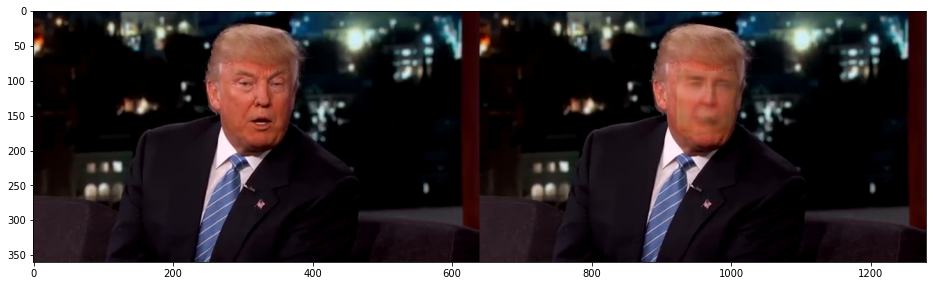

In [107]:
image_files = sorted(glob("data/images/test/input/*"))
image = np.asarray(Image.open(image_files[100]), dtype=np.uint8)
plt.figure(figsize=(16,10))
output_image = swap_face(image, ae_b2a)
plt.imshow(np.concatenate([image, output_image], axis=1))

In [ ]:
i = 0
for fname in tqdm(image_files):
    i+=1
    image = np.asarray(Image.open(fname), dtype=np.uint8)
    output = swap_face(image, ae_b2a)
    out_fname = fname.replace('/input/', '/output/')
    
    if output is not None:
        Image.fromarray(output).save(out_fname)    
    else:
        print("miss", i)
        Image.fromarray(image).save(out_fname)

In [ ]:
!rm fake_video.mp4
!ffmpeg -r 25 -start_number 1 -i data/images/test/output/image_%04d.png -vcodec mpeg4 fake_video.mp4 